In [1]:
import pandas as pd
import numpy as np

random_df = pd.read_csv('random_tweets_processed.csv')
depressed_df = pd.read_csv('depressive_tweets_processed.csv')
random_df.tweet = random_df.tweet.astype(str)
depressed_df.tweet = depressed_df.tweet.astype(str)

np.random.seed(1234)

In [2]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [3]:
X_r = random_df['tweet'].tolist()
X_d = depressed_df['tweet'].tolist()

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(X_d + X_r)

In [5]:
sequence_d = tokenizer.texts_to_sequences(X_d)
sequence_r = tokenizer.texts_to_sequences(X_r)

In [6]:
data_d = pad_sequences(sequence_d, maxlen=280)
data_r = pad_sequences(sequence_r, maxlen=280)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 12635 unique tokens


In [8]:
nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words+1, 300))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < 20000:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [9]:
d_rows = len(data_d)
r_rows = len(data_r)

labels_d = np.array([1] * d_rows)
labels_r = np.array([0] * r_rows)

perm_d = np.random.permutation(d_rows)
train_d_idx = perm_d[:int((0.7)*(d_rows))]
val_d_idx = perm_d[int((0.7)*(d_rows)) : int((0.85)*(d_rows))]
test_d_idx = perm_d[int((0.85)*(d_rows)):]

perm_r = np.random.permutation(r_rows)
train_r_idx = perm_r[:int((0.7)*(r_rows))]
val_r_idx = perm_r[int((0.7)*(r_rows)) : int((0.85)*(r_rows))]
test_r_idx = perm_r[int((0.85)*(r_rows)):]

data_train = np.concatenate((data_d[train_d_idx], data_r[train_r_idx]))
labels_train = np.concatenate((labels_d[train_d_idx], labels_r[train_r_idx]))
data_val = np.concatenate((data_d[val_d_idx], data_r[val_r_idx]))
labels_val = np.concatenate((labels_d[val_d_idx], labels_r[val_r_idx]))
data_test = np.concatenate((data_d[test_d_idx], data_r[test_r_idx]))
labels_test = np.concatenate((labels_d[test_d_idx], labels_r[test_r_idx]))

perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [10]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPooling1D
from keras.layers import Activation, MaxPooling1D, BatchNormalization, GRU, Bidirectional, SpatialDropout1D

### LSTM + CNN

In [11]:
lstm_cnn_model = Sequential()

lstm_cnn_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=280, trainable=False))

lstm_cnn_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

lstm_cnn_model.add(MaxPooling1D(pool_size=2))

lstm_cnn_model.add(Dropout(0.2))

lstm_cnn_model.add(LSTM(300))

lstm_cnn_model.add(Dropout(0.2))

lstm_cnn_model.add(Dense(1, activation='sigmoid'))

In [12]:
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 300)          3790800   
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 140, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 140, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               438000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = lstm_cnn_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 58s 283ms/step - loss: 0.2863 - acc: 0.9007 - val_loss: 0.1070 - val_acc: 0.9643
Epoch 2/10
205/205 [==============================] - 64s 311ms/step - loss: 0.0742 - acc: 0.9761 - val_loss: 0.0955 - val_acc: 0.9693
Epoch 3/10
205/205 [==============================] - 63s 305ms/step - loss: 0.0504 - acc: 0.9827 - val_loss: 0.0771 - val_acc: 0.9800
Epoch 4/10
205/205 [==============================] - 68s 330ms/step - loss: 0.0444 - acc: 0.9847 - val_loss: 0.0590 - val_acc: 0.9822
Epoch 5/10
205/205 [==============================] - 71s 345ms/step - loss: 0.0330 - acc: 0.9881 - val_loss: 0.0558 - val_acc: 0.9843
Epoch 6/10
205/205 [==============================] - 69s 336ms/step - loss: 0.0281 - acc: 0.9901 - val_loss: 0.0555 - val_acc: 0.9843
Epoch 7/10
205/205 [==============================] - 64s 313ms/step - loss: 0.0203 - acc: 0.9928 - val_loss: 0.0665 - val_acc: 0.9829
Epoch 8/10
205/205 [==============================] - 7

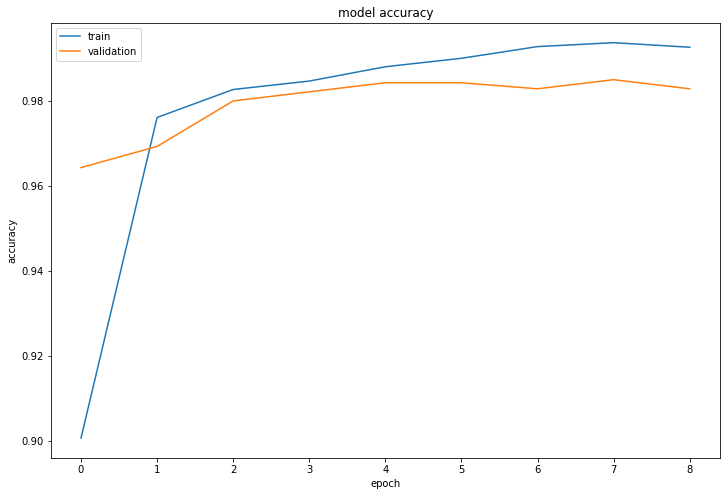

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

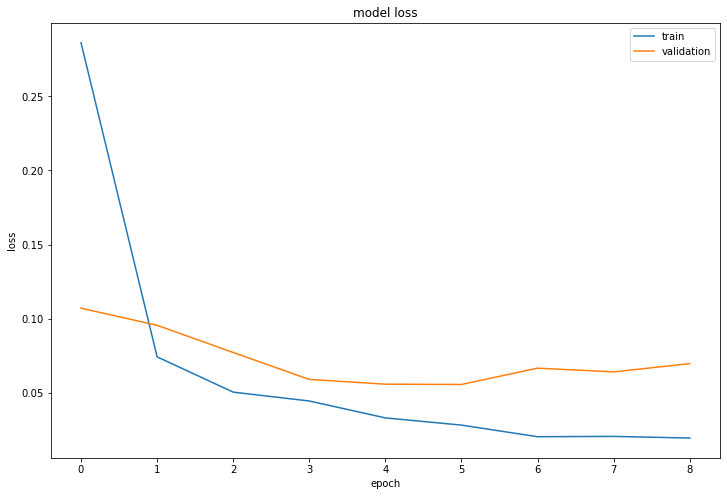

In [15]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

labels_pred = lstm_cnn_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.72%


In [18]:
from sklearn.metrics import  classification_report

print(classification_report(labels_test, labels_pred))
lstm_cnn_model.save('lstm_cnn.h5')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1206
           1       0.94      0.97      0.95       195

    accuracy                           0.99      1401
   macro avg       0.97      0.98      0.97      1401
weighted avg       0.99      0.99      0.99      1401



### LSTM

In [19]:
lstm_model = Sequential()

lstm_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=280, trainable=False))
lstm_model.add(LSTM(300))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

In [22]:
lstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 300)          3790800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 4,512,301
Trainable params: 721,501
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [23]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = lstm_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 179s 874ms/step - loss: 0.3015 - acc: 0.8983 - val_loss: 0.1743 - val_acc: 0.9358
Epoch 2/10
205/205 [==============================] - 205s 999ms/step - loss: 0.0873 - acc: 0.9749 - val_loss: 0.0874 - val_acc: 0.9722
Epoch 3/10
205/205 [==============================] - 202s 985ms/step - loss: 0.0608 - acc: 0.9832 - val_loss: 0.0935 - val_acc: 0.9693
Epoch 4/10
205/205 [==============================] - 222s 1s/step - loss: 0.0801 - acc: 0.9746 - val_loss: 0.0894 - val_acc: 0.9715
Epoch 5/10
205/205 [==============================] - 231s 1s/step - loss: 0.0458 - acc: 0.9861 - val_loss: 0.0585 - val_acc: 0.9836
Epoch 6/10
205/205 [==============================] - 213s 1s/step - loss: 0.0488 - acc: 0.9832 - val_loss: 0.0678 - val_acc: 0.9786
Epoch 7/10
205/205 [==============================] - 209s 1s/step - loss: 0.0445 - acc: 0.9862 - val_loss: 0.0634 - val_acc: 0.9800
Epoch 8/10
205/205 [==============================] - 210s 1

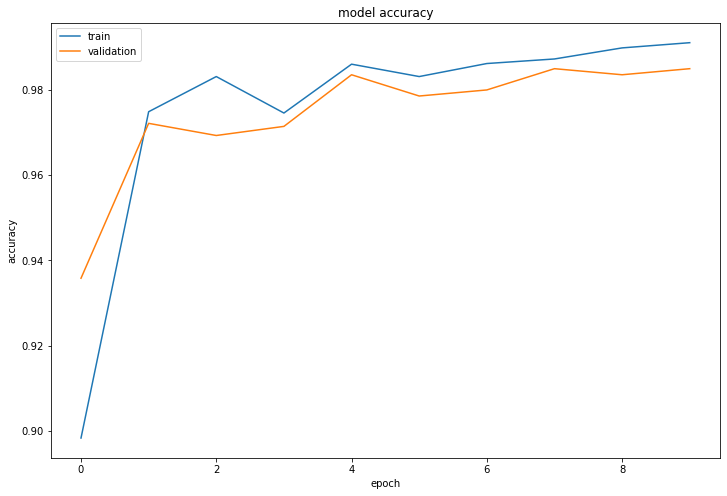

In [24]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

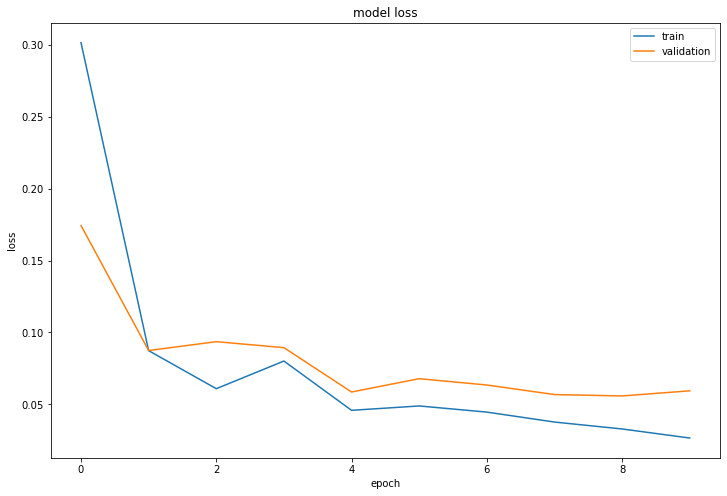

In [25]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [26]:
labels_pred = lstm_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.43%


In [27]:
print(classification_report(labels_test, labels_pred))
lstm_model.save('lstm.h5')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1206
           1       0.98      0.97      0.98       195

    accuracy                           0.99      1401
   macro avg       0.99      0.99      0.99      1401
weighted avg       0.99      0.99      0.99      1401



### CNN

In [29]:
cnn_model = Sequential()

cnn_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=280, trainable=False))
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [30]:
cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 280, 300)          3790800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 128)          192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 3,984,229
Trainable params: 193,429
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [31]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = cnn_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 9s 42ms/step - loss: 0.1516 - acc: 0.9564 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 2/10
205/205 [==============================] - 9s 46ms/step - loss: 0.0357 - acc: 0.9898 - val_loss: 0.0601 - val_acc: 0.9843
Epoch 3/10
205/205 [==============================] - 10s 48ms/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.0648 - val_acc: 0.9822
Epoch 4/10
205/205 [==============================] - 10s 48ms/step - loss: 0.0115 - acc: 0.9969 - val_loss: 0.0613 - val_acc: 0.9850
Epoch 5/10
205/205 [==============================] - 10s 48ms/step - loss: 0.0090 - acc: 0.9974 - val_loss: 0.0683 - val_acc: 0.9836


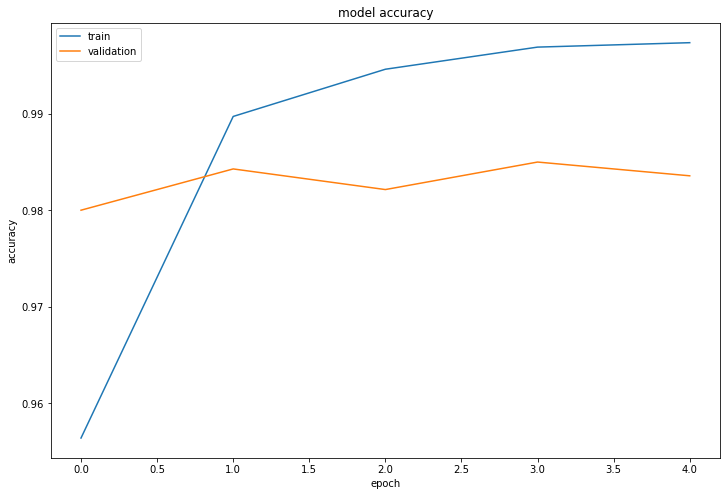

In [32]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

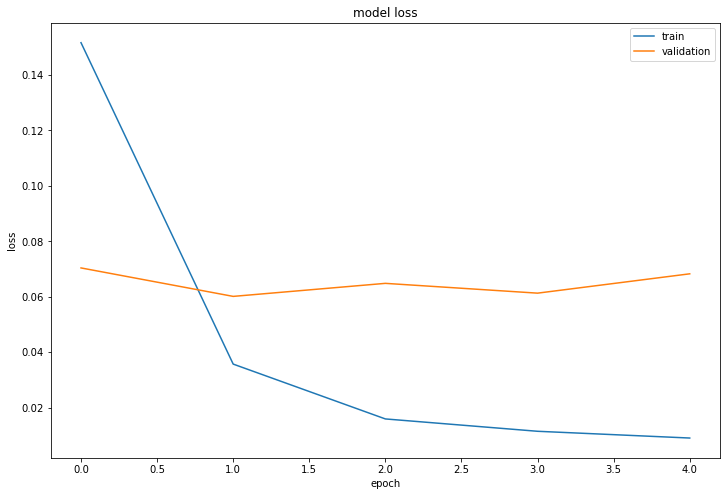

In [33]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [34]:
labels_pred = cnn_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.21%


In [35]:
print(classification_report(labels_test, labels_pred))
cnn_model.save('cnn.h5')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1206
           1       0.98      0.96      0.97       195

    accuracy                           0.99      1401
   macro avg       0.99      0.98      0.98      1401
weighted avg       0.99      0.99      0.99      1401



### GRU

In [36]:
gru_model = Sequential()

gru_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=280, trainable=False))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(Bidirectional(GRU(300)))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))

In [37]:
gru_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 280, 300)          3790800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 280, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1083600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 601       
Total params: 4,875,001
Trainable params: 1,084,201
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = gru_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 386s 2s/step - loss: 0.1338 - acc: 0.9564 - val_loss: 0.0769 - val_acc: 0.9793
Epoch 2/10
205/205 [==============================] - 391s 2s/step - loss: 0.0544 - acc: 0.9830 - val_loss: 0.0749 - val_acc: 0.9807
Epoch 3/10
205/205 [==============================] - 917s 4s/step - loss: 0.0431 - acc: 0.9881 - val_loss: 0.0652 - val_acc: 0.9822
Epoch 4/10
205/205 [==============================] - 372s 2s/step - loss: 0.0379 - acc: 0.9884 - val_loss: 0.3288 - val_acc: 0.9351
Epoch 5/10
205/205 [==============================] - 379s 2s/step - loss: 0.0468 - acc: 0.9853 - val_loss: 0.0606 - val_acc: 0.9822
Epoch 6/10
205/205 [==============================] - 396s 2s/step - loss: 0.0286 - acc: 0.9919 - val_loss: 0.0601 - val_acc: 0.9857
Epoch 7/10
205/205 [==============================] - 400s 2s/step - loss: 0.0236 - acc: 0.9910 - val_loss: 0.0660 - val_acc: 0.9850
Epoch 8/10
205/205 [==============================] - 393s 2s/step - 

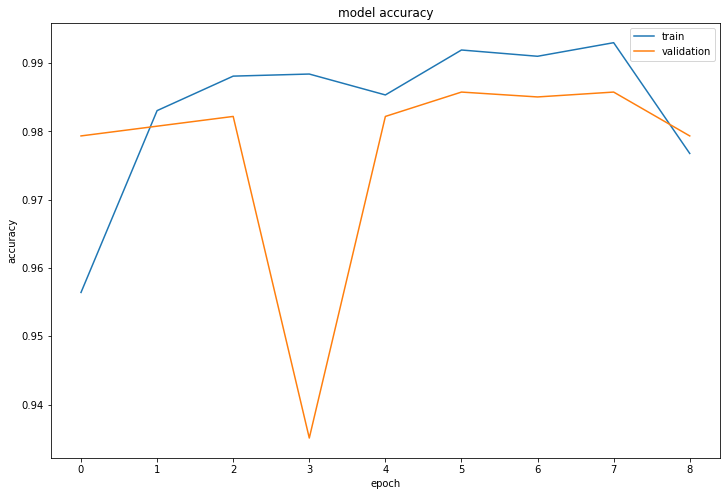

In [39]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

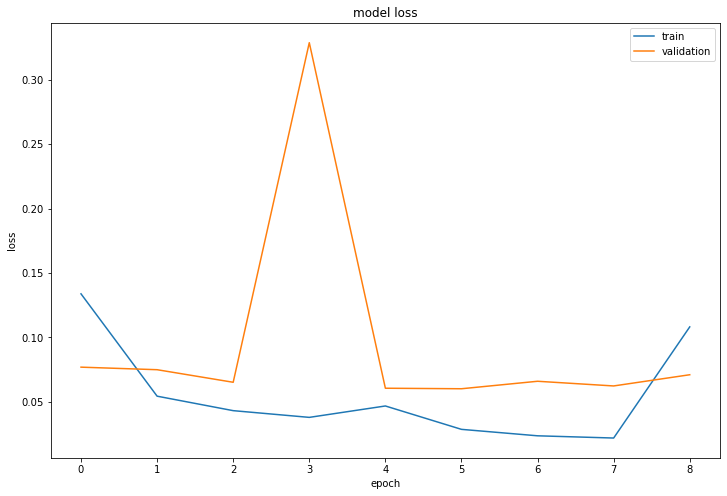

In [40]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [41]:
labels_pred = gru_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.50%


In [42]:
print(classification_report(labels_test, labels_pred))
gru_model.save('gru.h5')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.99      0.90      0.94       195

    accuracy                           0.99      1401
   macro avg       0.99      0.95      0.97      1401
weighted avg       0.99      0.99      0.98      1401



### Baseline (Logistic Regression)

In [43]:
X_train = np.concatenate((data_train, data_val))
y_train = np.concatenate((labels_train, labels_val))

In [44]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train, y_train)
accuracy = logreg.score(data_test, labels_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 86.87%
